Sources            SpT    log(T_{star}/K)    Distance             log frac{l_{\star}}{L_{\odot}}    Stellar mass (M_{\star})
-----------------  -----  -----------------  -------------------  --------------------------------  --------------------------
J15354856-2958551  M4     3.51\pm0.02        87.84(-1.05,+1.07)   -1.035(0.046,-0.046)              0.27(0.13,-0.1)
J15514032-2146103  M4     3.51\pm0.02        140.84(-0.79,+0.8)   -1.335(0.096,-0.096)              0.27(0.13,-0.1)
J15521088-2125372  M4     3.51\pm0.02        154.94(-5.02,+5.36)  -1.752(0.117,-0.117)              0.27(0.13,-0.1)
J15530132-2114135  M4     3.51\pm0.02        143.04(-1.05,+1.06)  -1.212(0.099,-0.099)              0.27(0.13,-0.1)
J15534211-2049282  M3.5   3.52\pm0.02        145.0(-20.0,+20.0)   -0.84(0.14,-0.14)                 0.33(0.16,-0.12)
J15551704-2322165  M2.5   3.54\pm0.02        145.0(-20.0,+20.0)   -0.54(0.15,-0.15)                 0.49(0.18,-0.16)
J15554883-2512240  G3     3.77\pm0.01        143.5

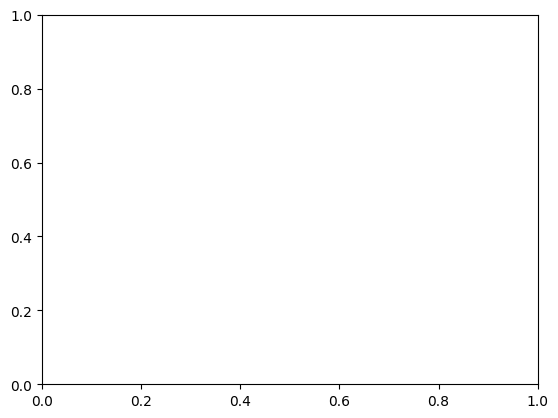

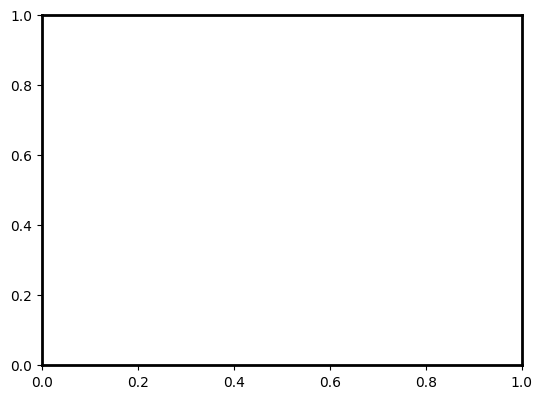

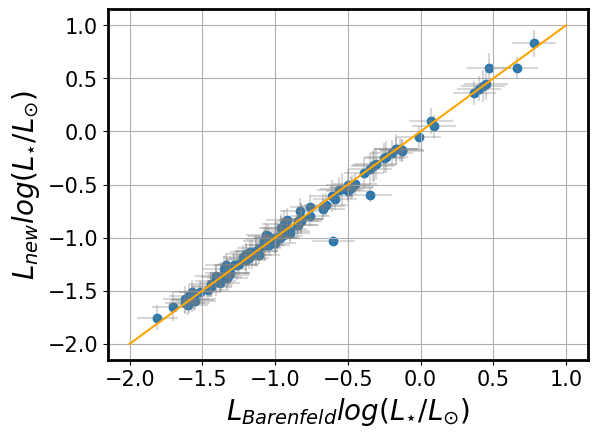

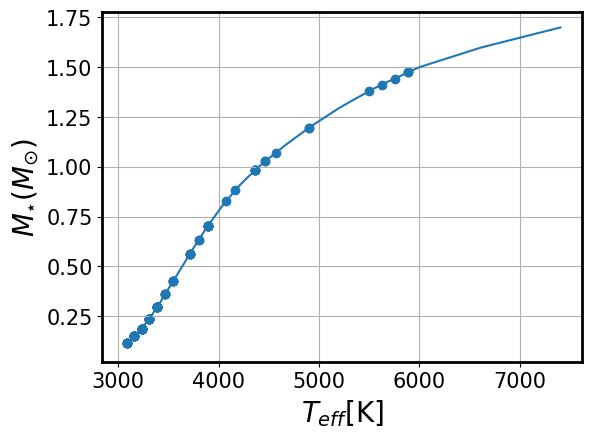

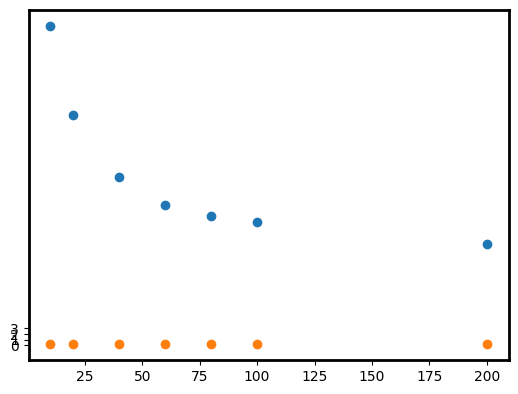

[-2, -3, 0, -9, -9, -7, -3, -46, 0, -2, -16, -2, -1, -5, -4, -2, 0, -7, -3, -8, -2, -2, -1, -3]


/Users/mauro/Library/CloudStorage/Dropbox/GitHub/Upper-Sco-2022/Table_3.py:103: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_3_pandas.to_latex('Table 3 pandas.tex', index=False, longtable=True, escape=False, column_format='lcccccc')


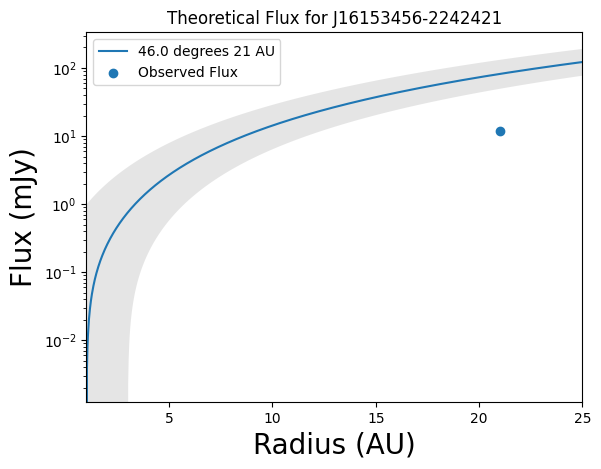

Flux at 21 AU: 81.88877240612763


In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
import numpy as np
from scipy.integrate import quad
from astropy import constants

from data_file import source_list_garrett, luminosity_list_barenfeld_updated, radius_dust_updated, lower_bound_radius_updated, upper_bound_radius_updated, flux_list_2_87mm_garrett, flux_barenfeld_0_88mm_updated
from Table_1 import distances_106
from Table_2 import surface_density_list
from Table_3 import opacity_list_3mm, opacity_list_0_87mm, temperature_list_van_der_plas

# All constants are in CGS units
wavelength_list = [0.088, 0.287]
c = constants.c.cgs.value
h = constants.h.cgs.value
k_b = constants.k_B.cgs.value
s_b = constants.sigma_sb.cgs.value
L_sun = constants.L_sun.cgs.value
c = constants.c.cgs.value

# Defining the star's name and finding its index in the data list
star_name = "J16153456-2242421"
index_star = source_list_garrett.index(star_name)

# Defining some values that can be changed to produce different results
flaring = 0.02
log_L_star = luminosity_list_barenfeld_updated[index_star]
L_star = (10 ** log_L_star) * L_sun
k_v_3mm = opacity_list_3mm[index_star]
k_v_0_87mm = opacity_list_0_87mm[index_star]
sur_den_0 = surface_density_list[index_star]

temperature_star = temperature_list_van_der_plas[index_star]
AU_in_cm = 1.5 * 10 ** 13
d = distances_106[index_star] * AU_in_cm
R_in = 1 *AU_in_cm
R_out = radius_dust_updated[index_star] * AU_in_cm
R_out_list = np.linspace(1, 25, 1000) * AU_in_cm
R_out_lower_error = lower_bound_radius_updated[index_star] * AU_in_cm
R_out_upper_error = upper_bound_radius_updated[index_star] * AU_in_cm

# Defining the function to be integrated
function_to_integrate = lambda R, planck_function_wavelength: planck_function_wavelength * R

def planck_function_frequency(frequency, temperature):
    """
    Returns the Planck function at a given frequency and temperature.
    """
    exponent = h*frequency/(k_b*temperature)
    return 2*h*frequency**3/c**2 * 1/(np.exp(exponent)-1)

def integrated_planck_radius(R_in, R_out, temperature):
    """
    Integrates the Planck function multiplied by the radius from R_in to R_out.
    Returns the result in units of erg/s/cm^2.
    """
    function_to_integrate = lambda R, temperature: 4*np.pi*R**2*planck_function_frequency(c/0.088, temperature)
    result, _ = quad(function_to_integrate, R_in, R_out, args=(temperature,))
    return result

def passive_T(R, L_star, flaring=0.02):
    T = (flaring * L_star / (8 * np.pi * R ** 2 * s_b)) ** (1/4)
    return T

def final(i, d, R_in, R_out, L_star, flaring=0.02):
    """
    Calculates the flux from the dust at a given inclination angle (i).
    """
    theoretical_flux = 2 * np.pi * np.cos(i) * integrated_planck_radius(R_in, R_out, passive_T(R_out, L_star, flaring=0.02)) / (d**2)
    return theoretical_flux

i = 46 * np.pi/180
i_lower_error = 21 * np.pi/180
i_upper_error = 12 * np.pi/180
# for i in radians from 'x' degrees i = x * np.pi/180
# for i in degrees from 'x' radians i = x * 180/np.pi

# Calculating the flux for the given inclination angle and radius
flux_values_0_88mm = []
flux_values_0_88mm_lower_error = []
flux_values_0_88mm_upper_error = []
for radiuses in R_out_list:
    flux_values_0_88mm.append(final(i, d, R_in, radiuses, L_star, flaring=0.02))
    flux_values_0_88mm_lower_error.append(final(i - i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star, flaring=0.02))
    flux_values_0_88mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star, flaring=0.02))

i = i * 180/np.pi
i_lower_error = i_lower_error * 180/np.pi
i_upper_error = i_upper_error * 180/np.pi

if __name__ == '__main__':
    plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm, label= str(i) + " degrees " + str(21) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
    plt.fill_between(R_out_list/AU_in_cm, flux_values_0_88mm_lower_error, flux_values_0_88mm_upper_error, alpha=0.2, facecolor='gray')
    plt.scatter(radius_dust_updated[index_star], flux_barenfeld_0_88mm_updated[index_star], label='Observed Flux')
    plt.xlim(1,25)

    plt.title("Theoretical Flux for J16153456-2242421")
    plt.xlabel("Radius (AU)", fontsize=20), plt.ylabel("Flux (mJy)", fontsize=20)
    plt.legend()
    plt.yscale('log')
    plt.savefig('J16153456-2242421 theoretical and measured flux 0.88mm.png')
    ax.tick_params(which='both', labelsize=15)


    plt.show()

i = 46 * np.pi/180
flux_21AU = final(i, d, R_in, 21.012 * AU_in_cm, L_star, flaring=0.02)
print('Flux at 21 AU:', flux_21AU)

In [3]:
print(round(flux_barenfeld_0_88mm_updated[index_star]/flux_21AU * 100, 2), '%')

14.35 %


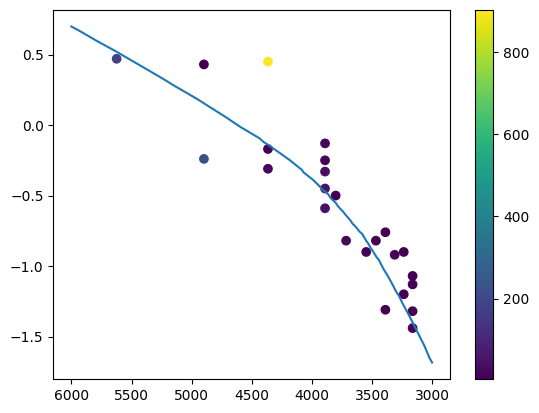

In [36]:
# create colorbar
# create scatter of stars spectral index vs flux_1mm
from data_file import temperature_list_barenfeld_updated
from Table_2 import spectral_index_upper_sco
from HR_Diagram import f10

temperature_list_barenfeld_updated = [10**x for x in temperature_list_barenfeld_updated]
plt.scatter(temperature_list_barenfeld_updated, luminosity_list_barenfeld_updated , c=flux_barenfeld_0_88mm_updated, label='Observed Flux')

x = np.linspace(3000, 6000, 1000)
plt.plot(x, f10(x), label='Spectral Index')

# calculate distance between each point and the line and store in a list
distance = []
for i in range(len(temperature_list_barenfeld_updated)):
    distance.append(abs((luminosity_list_barenfeld_updated[i] - f10(temperature_list_barenfeld_updated[i]))/np.sqrt(1 + f10(temperature_list_barenfeld_updated[i])**2)))

# normalize the distance list
distance = [x/max(distance) for x in distance]

plt.gca().invert_xaxis()
plt.colorbar()

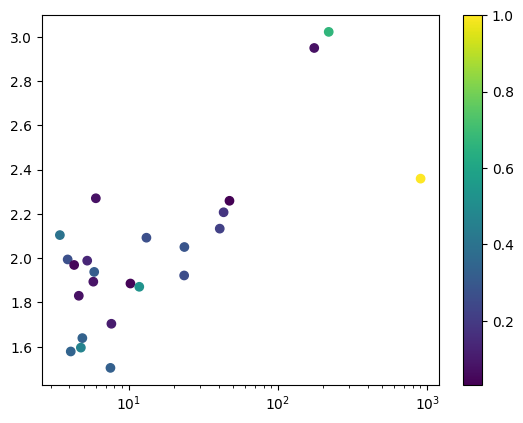

In [37]:
plt.scatter(flux_barenfeld_0_88mm_updated, spectral_index_upper_sco, c=distance)

plt.xscale('log')
plt.colorbar()

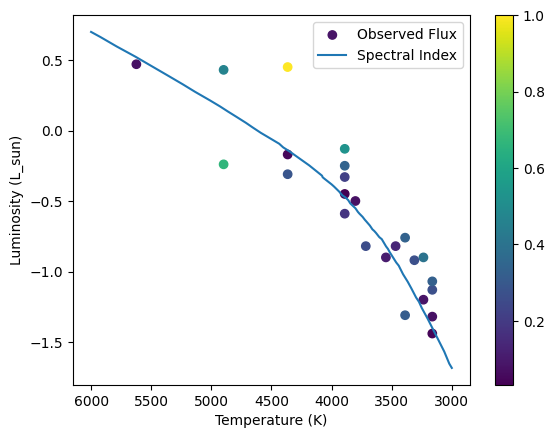

In [39]:
plt.scatter(temperature_list_barenfeld_updated, luminosity_list_barenfeld_updated , c=distance, label='Observed Flux')
plt.xlabel('Temperature (K)'), plt.ylabel('Luminosity (L_sun)')
plt.colorbar()
plt.gca().invert_xaxis()

x = np.linspace(3000, 6000, 1000)
plt.plot(x, f10(x), label='Spectral Index')
plt.legend()
plt.show()